In [1]:
%matplotlib inline

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy
import emcee

from ctisim.image import ImageSimulator, SegmentSimulator
from ctisim.utils import OverscanParameterResults, ITL_AMP_GEOM
from ctisim.core import FloatingOutputAmplifier, LinearTrap, LogisticTrap
from ctisim.fitting import OverscanFitting, SimulatedTrapModel

# ITL Full Deferred Charge Model

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATASEC = '[4:512,1:2000]'                                                      
NAMPS   =                   16                                                  
CHECKSUM= 'QY2RQX1PQX1PQX1P'   / HDU checksum updated 2020-01-29T13:45:00       
DATASUM = '0       '           / data unit checksum updated 2020-01-29T13:45:00  



Text(0.5, 0, 'Signal [e-]')

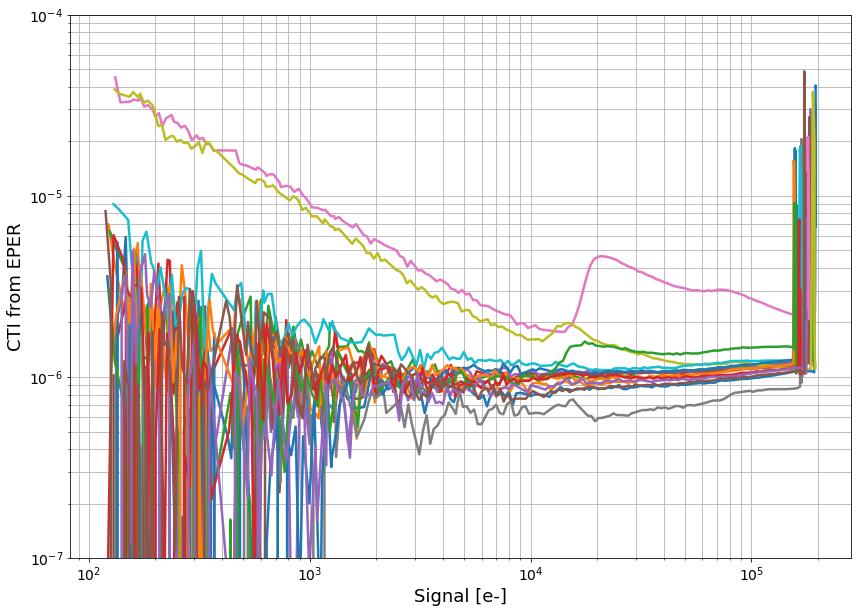

In [2]:
## Overscan results header
overscan_results = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R20/S02/R20_S02_overscan_results.fits'
hdul = fits.open(overscan_results)

prihdr = hdul[0].header
print(repr(prihdr), '\n')

fig, ax = plt.subplots(1, 1, figsize=(14, 10))

for amp in range(1, 17):
    data = hdul[amp].data
    signal_all = data['FLATFIELD_SIGNAL']
    indices = np.argsort(signal_all)
    signal_data = signal_all[indices]

    last_pix = data['COLUMN_MEAN'][:, 511]
    oscan1 = data['COLUMN_MEAN'][:, 512]
    #oscan2 = data['MEANROW'][:, 513]
    oscan2 = 0
    cti_data = ((oscan1+oscan2)/(512*last_pix))[indices]
      
    ax.plot(signal_data, cti_data, linewidth=2.5)
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

## Floating Output Amplifier Fitting

In [7]:
amp = 7

## Get data for comparison
overscan_results = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R20/S02/R20_S02_overscan_results.fits'
hdul = fits.open(overscan_results)

data = hdul[amp].data
signals = data['FLATFIELD_SIGNAL']

last_pix = data['COLUMN_MEAN'][:, 511]
oscan1 = data['COLUMN_MEAN'][:, 512]
oscan2 = data['COLUMN_MEAN'][:, 513]
cti_data = ((oscan1+oscan2)/(512*last_pix))[indices]
      
amp_fit_results = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R20/S02/R20_S02_overscan_fit_results.fits'
hdul = fits.open(amp_fit_results)

decay_times = hdul[1].data['DECAY_TIME']
drift_scales = hdul[1].data['DRIFT_SIZE']

output_amplifier = FloatingOutputAmplifier(1.0, drift_scales[amp-1]/10000., decay_times[amp-1], noise=0.0, offset=0.0)
print(output_amplifier.scale, output_amplifier.decay_time)

0.00015482474565505983 2.2577844


Text(0.5, 0, 'Signal [e-]')

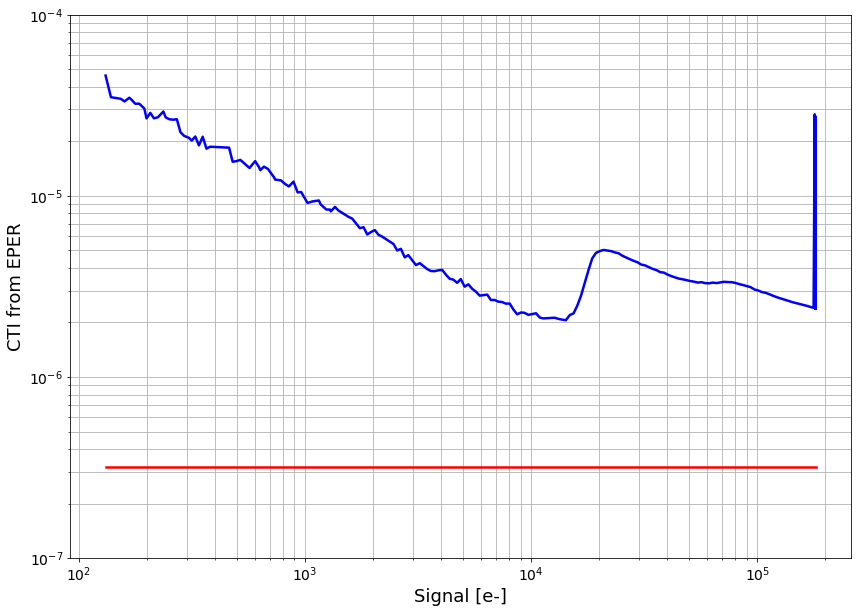

In [8]:
imarr = np.zeros((signals.shape[0], ITL_AMP_GEOM.nx))
ramp = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier)
ramp.ramp_exp(signals)

segarr = ramp.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width,
                               parallel_overscan_width=0)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
last_pix = segarr[:, 511]
oscan1 = segarr[:, 512]
oscan2 = segarr[:, 513]
cti_model = ((oscan1+oscan2)/(512*last_pix))
    
ax.plot(signals, cti_model, linewidth=2.5, color='red')
ax.plot(signals, cti_data, linewidth=2.5, color='blue')

    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

## Low Signal Trap Fitting

1.2739159371053477e-06


Text(0.5, 0, 'Signal [e-]')

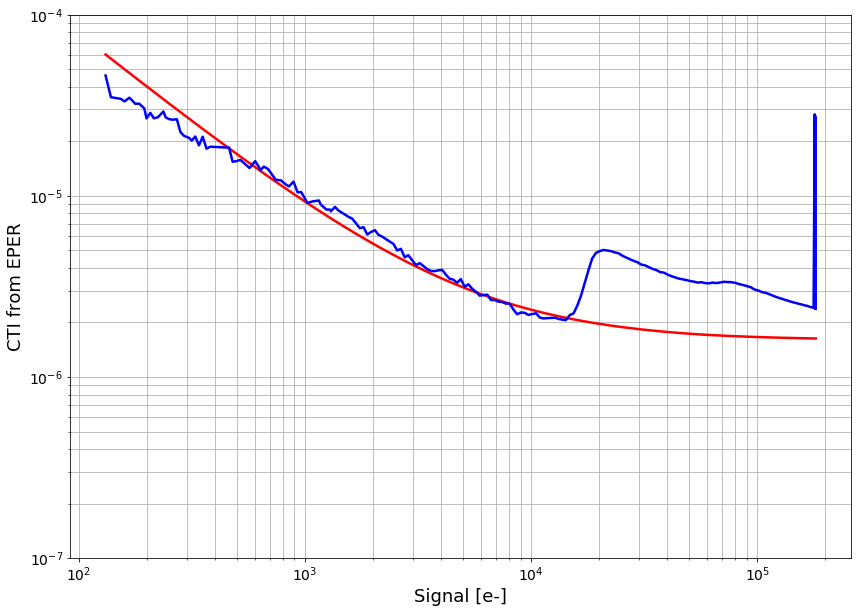

In [11]:
## Low signal trapping
low_mcmc_results = fits.open('../examples/output/R20_S02_Amp7_lowtrap_mcmc.fits')

## Trap parameters
amp=9
cti_chain = low_mcmc_results[1].data
trapsize_chain = low_mcmc_results[2].data
emission_time_chain = low_mcmc_results[3].data
scaling_chain = low_mcmc_results[4].data
cti = 10**np.median(cti_chain[:, 500:])
print(cti)

low_trap = LinearTrap(np.median(trapsize_chain[:, 500:]), np.median(emission_time_chain[:, 500:]), 1,
                      np.median(scaling_chain[:, 500:]))

## Make CTI curve
imarr = np.zeros((signals.shape[0], ITL_AMP_GEOM.nx))
ramp = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, 
                        cti=cti, traps=low_trap)
ramp.ramp_exp(signals)

segarr = ramp.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width,
                               parallel_overscan_width=0)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
last_pix = segarr[:, 511]
oscan1 = segarr[:, 512]
oscan2 = segarr[:, 513]
cti_model = ((oscan1+oscan2)/(512*last_pix))

ax.plot(signals, cti_model, linewidth=2.5, color='red')
ax.plot(signals, cti_data, linewidth=2.5, color='blue')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

## Mid Signal Trapping

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
SENSORID= 'R20_S02 '                                                            
AMP     =                    9                                                  
TYPE    = 'logistic'                                                            
STEPS   =                 5000                                                  
WALKERS =                   10                                                  
5.886244180832787e-07


Text(0.5, 0, 'Signal [e-]')

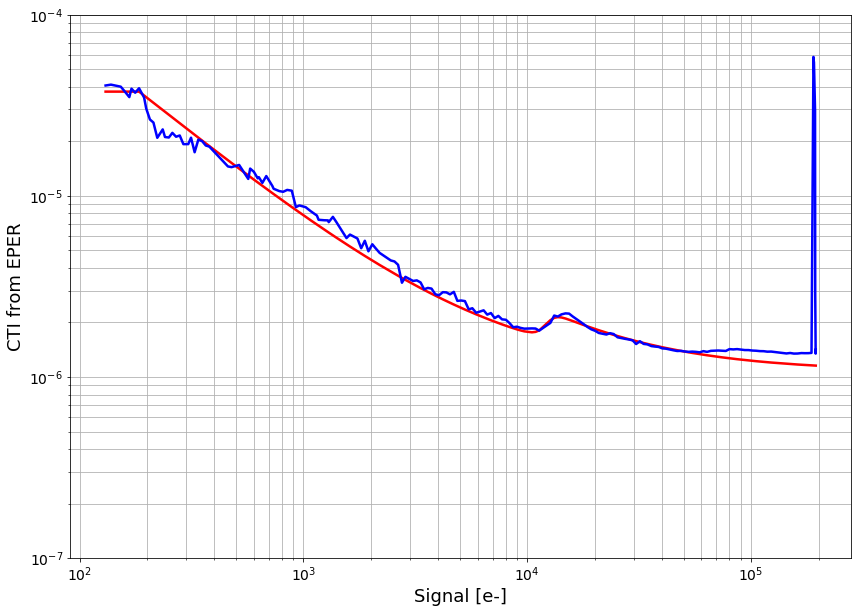

In [6]:
## Low signal trapping
#med_mcmc_results = fits.open('../examples/output/R20_S02_Amp9_medtrap_mcmc.fits')
med_mcmc_results = fits.open('../scripts/R20_S02_Amp9_medtrap_mcmc.fits')

print(repr(med_mcmc_results[0].header))
cti_chain = med_mcmc_results[1].data
trapsize_chain = med_mcmc_results[2].data
emission_time_chain = med_mcmc_results[3].data
f0_chain = med_mcmc_results[4].data
k_chain = med_mcmc_results[5].data

cti = 10**np.median(cti_chain[:, 500:])
print(cti)

med_trap = LogisticTrap(np.median(trapsize_chain[:, 500:]), np.median(emission_time_chain[:, 500:]), 1,
                      np.median(f0_chain[:, 500:]), np.median(k_chain[:, 500:]))

## Make CTI curve
imarr = np.zeros((signals.shape[0], ITL_AMP_GEOM.nx))
ramp = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, 
                        cti=cti, traps=[low_trap, med_trap])
ramp.ramp_exp(signals)

segarr = ramp.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width,
                               parallel_overscan_width=0)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
last_pix = segarr[:, 511]
oscan1 = segarr[:, 512]
oscan2 = segarr[:, 513]
cti_model = ((oscan1+oscan2)/(512*last_pix))

ax.plot(signals, cti_model, linewidth=2.5, color='red')
ax.plot(signals, cti_data, linewidth=2.5, color='blue')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)